Using the `StandardScalar` class from the data processing toolkit `preprocessing` in `sklearn`  
fit() function of the class computes the mean and variance from the input data and normalizes the data with the results to a mean of 0 and a variance of 1

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from sklearn.preprocessing import StandardScaler

# Load the data, output the characteristics of the view data
lines = np.loadtxt('USA_Housing.csv', delimiter=',', dtype='str')
header = lines[0]
lines = lines[1:].astype(float)
print('feature:', ','.join(header[:-1]))
print('labels:', header[-1])
print('total number of data entries:', len(lines))

# Divide train and test sets
ratio = 0.8
split = int(len(lines) * ratio)
np.random.seed(0)
lines = np.random.permutation(lines)
train, test = lines[:split], lines[split:]

# Normalization
scaler = StandardScaler()
scaler.fit(train) # only use data in train set to computes the mean and variance
train = scaler.transform(train)
test = scaler.transform(test)

# Divide input and labels
x_train, y_train = train[:,:-1], train[:, -1].flatten()
x_test, y_test = test[:, :-1], test[:, -1].flatten()

feature: Avg. Area Income,Avg. Area House Age,Avg. Area Number of Rooms,Avg. Area Number of Bedrooms,Area Population
labels: Price
total number of data entries: 5000


Use MSE as the loss function during training and RMSE(rooted mean squared error) as the evaluation metric for the model

$$f_{\theta}(X)=X\theta = X(X^TX)^{-1}X^{T}y$$

In [9]:
# Add a column 1 at the end of X matrix, represening the constant term
X = np.concatenate([x_train, np.ones((len(x_train), 1))], axis=-1)
# @Matrix multiplication, X T represents the transpose of matrix X, and the 
# np.final.inv function can calculate the inverse of the matrix
theta = np.linalg.inv(X.T @ X) @ X.T @ y_train # np.linalg.inv(Compute the inverse of this product)
print('regression coefficient:', theta)

# Regression coefficient are used to make predictions on the test set
X_test = np.concatenate([x_test, np.ones((len(x_test), 1))], axis=-1)
y_pred = X_test @ theta

# Calculate the RMSE between the predicted value and the true value
rmse_loss = np.sqrt(np.square(y_test - y_pred).mean())
print('RMSE:', rmse_loss)

regression coefficient: [ 6.50881254e-01  4.67222833e-01  3.38466198e-01  6.17275856e-03
  4.26857089e-01 -1.46033359e-14]
RMSE: 0.28791834247503534


Use LinearRegression in sklearn

In [13]:
from sklearn.linear_model import LinearRegression

# Initializes the linear model
linreg = LinearRegression()
# LinearRegression的方法中已经考虑了线性回归的常数项，所以无须再拼接1
linreg.fit(x_train, y_train)

# coef_ is regression coefficient after train, intercept_ is constant terms
print('Regression coefficient:', linreg.coef_, linreg.intercept_)
y_pred = linreg.predict(x_test)

# Calculate the RMSE between the predicted value and the true value
rmse_loss = np.sqrt(np.square(y_test - y_pred).mean())
print('RMSE:', rmse_loss)

Regression coefficient: [0.65088125 0.46722283 0.3384662  0.00617276 0.42685709] -1.4635041882766186e-14
RMSE: 0.28791834247503534


---
**梯度下降算法**

When involving a large number of matrix operations, the time cost is relatively high. We use gradient descent algorithm for numerical simulation to achieve numerical solutions with minimal error compared to analytical solutions.
In gradient descent, small batch random gradient descent, abbreviated as MBGD, is commonly used.

In [22]:
# This function return a batch size of batch at a time
# x is input, y is label
# if shuffle == True: each traversal redivides the data randomly
def batch_generator(x, y, batch_size, shuffle=True):
    # Batch counter
    batch_count = 0
    if shuffle:
        # Randomly generate subscripts of 0 to len(x) - 1
        idx = np.random.permutation(len(x))
        x = x[idx]
        y = y[idx]
    while True:
        start = batch_count * batch_size
        end = min(start + batch_size, len(x))
        if start >= end:
            break
        batch_count += 1
        yield x[start: end], y[start: end]

Regression coefficient: [ 0.65357756  0.46682964  0.33885411  0.00720843  0.42751035 -0.00273407]


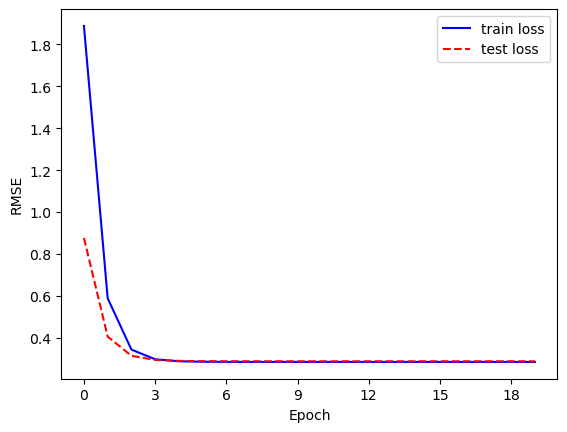

In [25]:
def SGD(num_epoch, learning_rate, batch_size):
    # Splice the original matrix
    X = np.concatenate([x_train, np.ones((len(x_train), 1))], axis=-1)
    X_test = np.concatenate([x_test, np.ones((len(x_test), 1))], axis=-1)
    # Random initialization parameters
    theta = np.random.normal(size=X.shape[1])
    
    # SGD
    train_losses = []
    test_losses = []
    for i in range(num_epoch):
        # Initializes batch generator
        batch_g = batch_generator(X, y_train, batch_size, shuffle=True)
        train_loss = 0
        for x_batch, y_batch in batch_g:
            # calculate gradient
            grad = x_batch.T @ (x_batch @ theta - y_batch)
            # updata parameters
            theta = theta  - learning_rate * grad / len(x_batch)
            # cumulative square error
            train_loss += np.square(x_batch @ theta - y_batch).sum()
        # calculate train_loss and test_loss
        train_loss = np.sqrt(train_loss / len(X))
        train_losses.append(train_loss)
        test_loss = np.sqrt(np.square(X_test @ theta - y_test).mean())
        test_losses.append(test_loss)
        
    print('Regression coefficient:', theta)
    return theta, train_losses, test_losses


num_epoch = 20
learning_rate = 0.01
batch_size = 32
np.random.seed(0)

_, train_losses, test_losses = SGD(num_epoch, learning_rate, batch_size)

# Charting the relationship between the loss function and the running times
# Can see the loss function keeps decreasing at first and the tends to be stable
plt.plot(np.arange(num_epoch), train_losses, color='blue', label='train loss')
plt.plot(np.arange(num_epoch), test_losses, color='red', ls='--', label='test loss')

plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.legend()
plt.show()

**The effect of learning rate on iteration**  
learning rate is a key parameter 

Regression coefficient: [ 0.66327638  0.46555555  0.33909153 -0.00167519  0.44128146 -0.00318577]
Regression coefficient: [ 0.45282878  0.49685917  0.49510686 -0.21996969  0.42216171 -0.09010888]


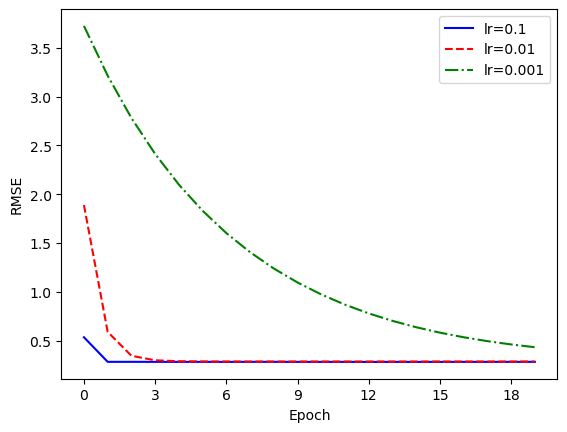

In [27]:
_, loss1, _ = SGD(num_epoch=num_epoch, learning_rate=0.1,
    batch_size=batch_size)
_, loss2, _ = SGD(num_epoch=num_epoch, learning_rate=0.001,
    batch_size=batch_size)
plt.plot(np.arange(num_epoch), loss1, color='blue',
    label='lr=0.1')
plt.plot(np.arange(num_epoch), train_losses, color='red',
    ls='--', label='lr=0.01')
plt.plot(np.arange(num_epoch), loss2, color='green',
    ls='-.', label='lr=0.001')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.legend()
plt.show()

Regression coefficient: [ 5.77637606e+79 -4.83668911e+80  3.25996549e+80  4.23825401e+80
  4.71711285e+80  2.86687587e+78]
最终损失： 5.561487004223495e+80


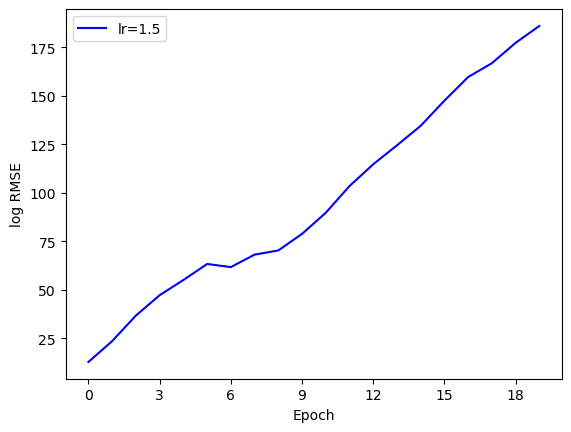

In [28]:
_, loss3, _ = SGD(num_epoch=num_epoch, learning_rate=1.5, batch_size=batch_size)
print('最终损失：', loss3[-1])
plt.plot(np.arange(num_epoch), np.log(loss3), color='blue', label='lr=1.5')
plt.xlabel('Epoch')
plt.ylabel('log RMSE')
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.legend()
plt.show()

In [36]:
def SGD_with_early_stopping(num_epoch, learning_rate, batch_size, tolerance=1e-4):
    # Splice the original matrix
    X = np.concatenate([x_train, np.ones((len(x_train), 1))], axis=-1)
    X_test = np.concatenate([x_test, np.ones((len(x_test), 1))], axis=-1)
    # Random initialization parameters
    theta = np.random.normal(size=X.shape[1])
    
    # SGD
    train_losses = []
    test_losses = []
    prev_train_loss = float('inf')
    
    for i in range(num_epoch):
        # Initializes batch generator
        batch_g = batch_generator(X, y_train, batch_size, shuffle=True)
        train_loss = 0
        
        for x_batch, y_batch in batch_g:
            # calculate gradient
            grad = x_batch.T @ (x_batch @ theta - y_batch)
            # updata parameters
            theta = theta - learning_rate * grad / len(x_batch)
            # cumulative square error
            train_loss += np.square(x_batch @ theta - y_batch).sum()
        
        # calculate train_loss and test_loss
        train_loss = np.sqrt(train_loss / len(X))
        train_losses.append(train_loss)
        test_loss = np.sqrt(np.square(X_test @ theta - y_test).mean())
        test_losses.append(test_loss)
        
        # Early stopping condition
        if prev_train_loss - train_loss < tolerance:
            print(f"Converged at epoch {i}")
            break
        
        prev_train_loss = train_loss
        
    print('Regression coefficient:', theta)
    return theta, train_losses, test_losses


Regression coefficient: [ 0.6782623   0.46483798  0.3334124   0.02427615  0.42238209 -0.01294078]
Regression coefficient: [ 0.6932706   0.46350117  0.32753102  0.01608571  0.40715256 -0.00810437]
Regression coefficient: [ 0.68815031  0.49743939  0.25845379 -0.06751029  0.314027    0.05397593]
Regression coefficient: [ 0.6690598   0.52707494  0.15790093 -0.17362579  0.24630456  0.14527655]
Regression coefficient: [ 0.66358455  0.53279686  0.13010409 -0.20276518  0.23189071  0.16871622]


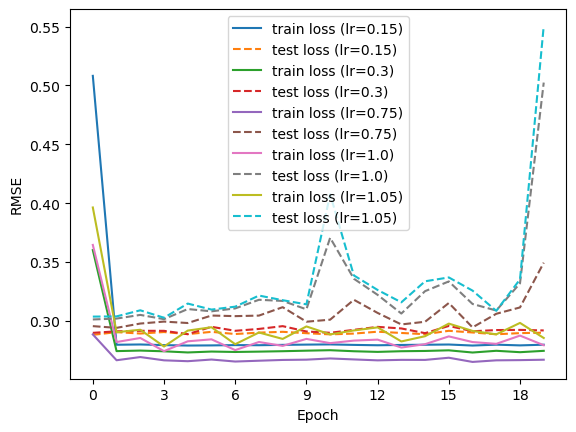

In [37]:
# 不同学习率列表
learning_rates = [0.15, 0.3, 0.75, 1.0, 1.05]

# 设置迭代次数和批量大小
num_epoch = 20
batch_size = 32

# 绘制不同学习率下的收敛效果
for lr in learning_rates:
    # 重新种子以确保每次运行结果一致
    np.random.seed(0)
    
    # 运行SGD函数
    _, train_losses, test_losses = SGD(num_epoch, lr, batch_size)
    
    # 绘制图表
    plt.plot(np.arange(num_epoch), train_losses, label=f'train loss (lr={lr})')
    plt.plot(np.arange(num_epoch), test_losses, ls='--', label=f'test loss (lr={lr})')

plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.legend()
plt.show()
